In [1]:
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
import scipy as sp
import pywt # wavelet transforms
from pathlib import Path
from typing import Optional, Union
from tqdm import tqdm

import warnings
warnings.filterwarnings('ignore')

IMG_FOLDER = Path('./report/src/img/')
IMG_FOLDER.mkdir(parents=True, exist_ok=True)
TBLS_FOLDER = Path('./report/src/tbls/')
TBLS_FOLDER.mkdir(parents=True, exist_ok=True)

In [2]:
# read Q{1,2,3}.mat
q1 = sp.io.loadmat('./data/Q1.mat')
Fs = 8192 # sampling frequency in Hz (specified in the assignment description)
q2 = sp.io.loadmat('./data/Q2.mat')
q3 = sp.io.loadmat('./data/Q3.mat')

In [3]:
print(q1.keys())
print(q2.keys())
print(q3.keys())

dict_keys(['__header__', '__version__', '__globals__', 'y'])
dict_keys(['__header__', '__version__', '__globals__', 'EEG'])
dict_keys(['__header__', '__version__', '__globals__', 'noisy_EEG'])


In [4]:
y = q1['y']
y = y.squeeze()
print(y.shape)
EEG = q2['EEG']
EEG = EEG.squeeze()
print(EEG.shape)
noisy_EEG = q3['noisy_EEG']
noisy_EEG = noisy_EEG.squeeze()
print(noisy_EEG.shape)

(73113,)
(2500,)
(2500,)


In [5]:
print('type(y):', type(y))
print('type(EEG):', type(EEG))
print('type(noisy_EEG):', type(noisy_EEG))
print('y.shape:', y.shape)
print('EEG.shape:', EEG.shape)
print('noisy_EEG.shape:', noisy_EEG.shape)

type(y): <class 'numpy.ndarray'>
type(EEG): <class 'numpy.ndarray'>
type(noisy_EEG): <class 'numpy.ndarray'>
y.shape: (73113,)
EEG.shape: (2500,)
noisy_EEG.shape: (2500,)


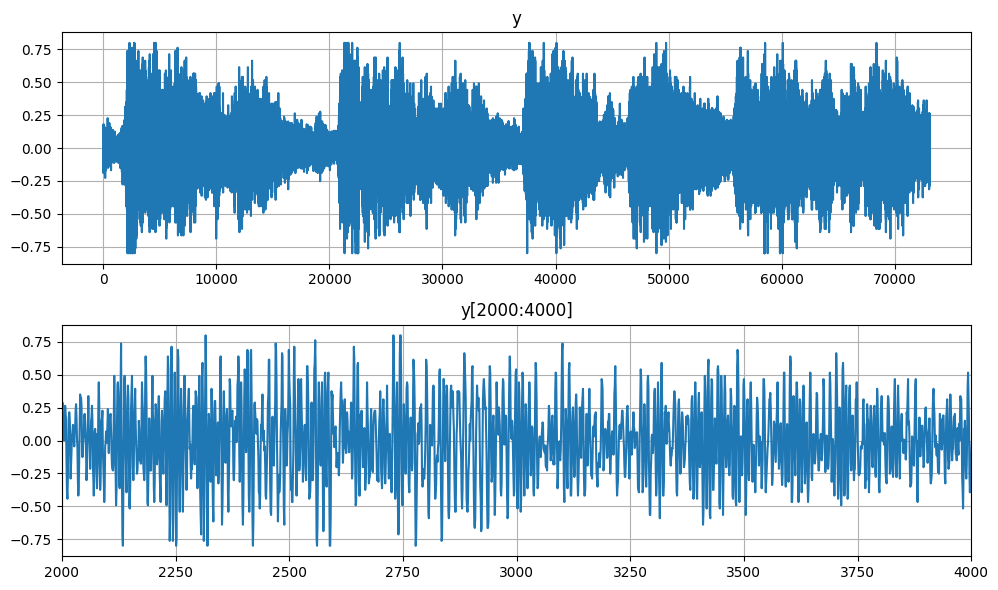

In [6]:
# plot Q1.mat data
_, axs = plt.subplots(2, 1, figsize=(10, 6))
axs[0].plot(y)
axs[0].set_title('y')
axs[0].grid()

zoomed_in_interval = (2000,4000)

axs[1].plot(y)
axs[1].set_title(f'y[{zoomed_in_interval[0]}:{zoomed_in_interval[1]}]')
axs[1].set_xlim(zoomed_in_interval)
axs[1].grid()

plt.tight_layout()
plt.savefig(IMG_FOLDER / 'Q1.pdf')
plt.show()


### 1.1 Plot the approximated and detailed coefficients

when you want to denoise the signal you use the **soft** threshholding. When you want to compress the signal you use the **hard** threshholding.

In [7]:
def extract_cA_and_cDs_from_wavedecn(coeffs, level: int, upsample: Optional[int] = None) -> tuple[np.ndarray, list[np.ndarray]]:
    """Extract cA and cDs from the output of `pywt.wavedec`"""
    print(f"len(coeffs): {len(coeffs)}")
    
    arr, coeff_slices = pywt.coeffs_to_array(coeffs)

    cDs = [
        arr[coeff_slices[level - i + 1]['da']]
        for i in range(1,level + 1)
    ]

    cA_at_level = arr[coeff_slices[0]]
    
    if upsample is not None:
        cDs = [
            sp.signal.resample(cD, len(y))
            for cD in cDs
        ]
        cA_at_level = sp.signal.resample(cA_at_level, len(y))


    return cA_at_level, cDs


In [8]:
# level = 3
# wavelet = 'db1'
# coeffs = pywt.wavedec(y, wavelet, level=level)
# cA_at_level, cDs = extract_cA_and_cDs_from_wavedecn(coeffs, level)


len(coeffs): 4


KeyError: 'da'

In [9]:
level = 3
wavelet = 'db1'

upsample = len(y)

coeffs = pywt.wavedec(y, wavelet, level=level) # db2 is the name of the Daubechies wavelet
assert len(coeffs) == level + 1, f"len(coeffs) should be {level + 1}, but got {len(coeffs)}"
cA_at_level = coeffs[0]
cDs = coeffs[1:]
cDs.reverse()

if upsample is not None:
    cDs = [
        sp.signal.resample(cD, upsample)
        for cD in cDs
    ]
    cA_at_level = sp.signal.resample(cA_at_level, upsample)




# arr, coeff_slices = pywt.coeffs_to_array(coeffs)
# print('arr.shape:', arr.shape)
# print('len(coeff_slices):' , len(coeff_slices))

# cDs = [
#     arr[coeff_slices[level - i + 1]['da']]
#     for i in range(1,level + 1)
# ]


# cA_at_level = arr[coeff_slices[0]]

# for i, cD in enumerate(cDs):
#     print(f'cD{i+1}.shape:', cD.shape)

# print('cA_at_level.shape:', cA_at_level.shape)

# cDs = [
#     sp.signal.resample(cD, len(y))
#     for cD in cDs
# ]

# cA_at_level = sp.signal.resample(cA_at_level, len(y))


# print("shape after upsampling:")
# for i, cD in enumerate(cDs):
#     print(f'cD{i+1}.shape:', cD.shape)

# print('cA_at_level.shape:', cA_at_level.shape)

In [10]:
def plot_decomposed_signal(cA: np.ndarray, cDs: list[np.ndarray], level: int, where_to_save_fig: str = None, figsize: tuple[int, int] = (16, 12)) -> None:
    assert level > 0, f"level {level} must be > 0"
    # assert level == len(cDs), f"level {level} should be equal to the number of cDs {len(cDs)}"

    rows = (level + 1) * 2
    cols = 1
    _, axs = plt.subplots(rows, cols, figsize=figsize)

    # plot the approximation coefficients at the deepest level
    cA_plot_color = 'orange'

    axs[0].plot(cA, linewidth=1, color=cA_plot_color)
    axs[0].set_title(f'cA{level}')
    axs[0].grid()
    axs[1].plot(cA, linewidth=1, color=cA_plot_color)
    axs[1].set_title('cA' + f'[{zoomed_in_interval[0]}:{zoomed_in_interval[1]}]')
    axs[1].set_xlim(zoomed_in_interval)
    axs[1].grid()


    # plot the detail coefficients at each level in descending order
    for i, coeff, title in zip([*range(2, rows, 2)], cDs, [f'cD{i+1}' for i in range(level)]):
        axs[i].plot(coeff, linewidth=1)
        axs[i].set_title(title)
        axs[i].grid()
        axs[i + 1].plot(coeff, linewidth=1)
        axs[i+ 1].set_title(title + f'[{zoomed_in_interval[0]}:{zoomed_in_interval[1]}]')
        axs[i+1].set_xlim(zoomed_in_interval)
        axs[i+1].grid()

    plt.tight_layout()
    if where_to_save_fig:
        plt.savefig(where_to_save_fig, format='pdf')

    plt.show()


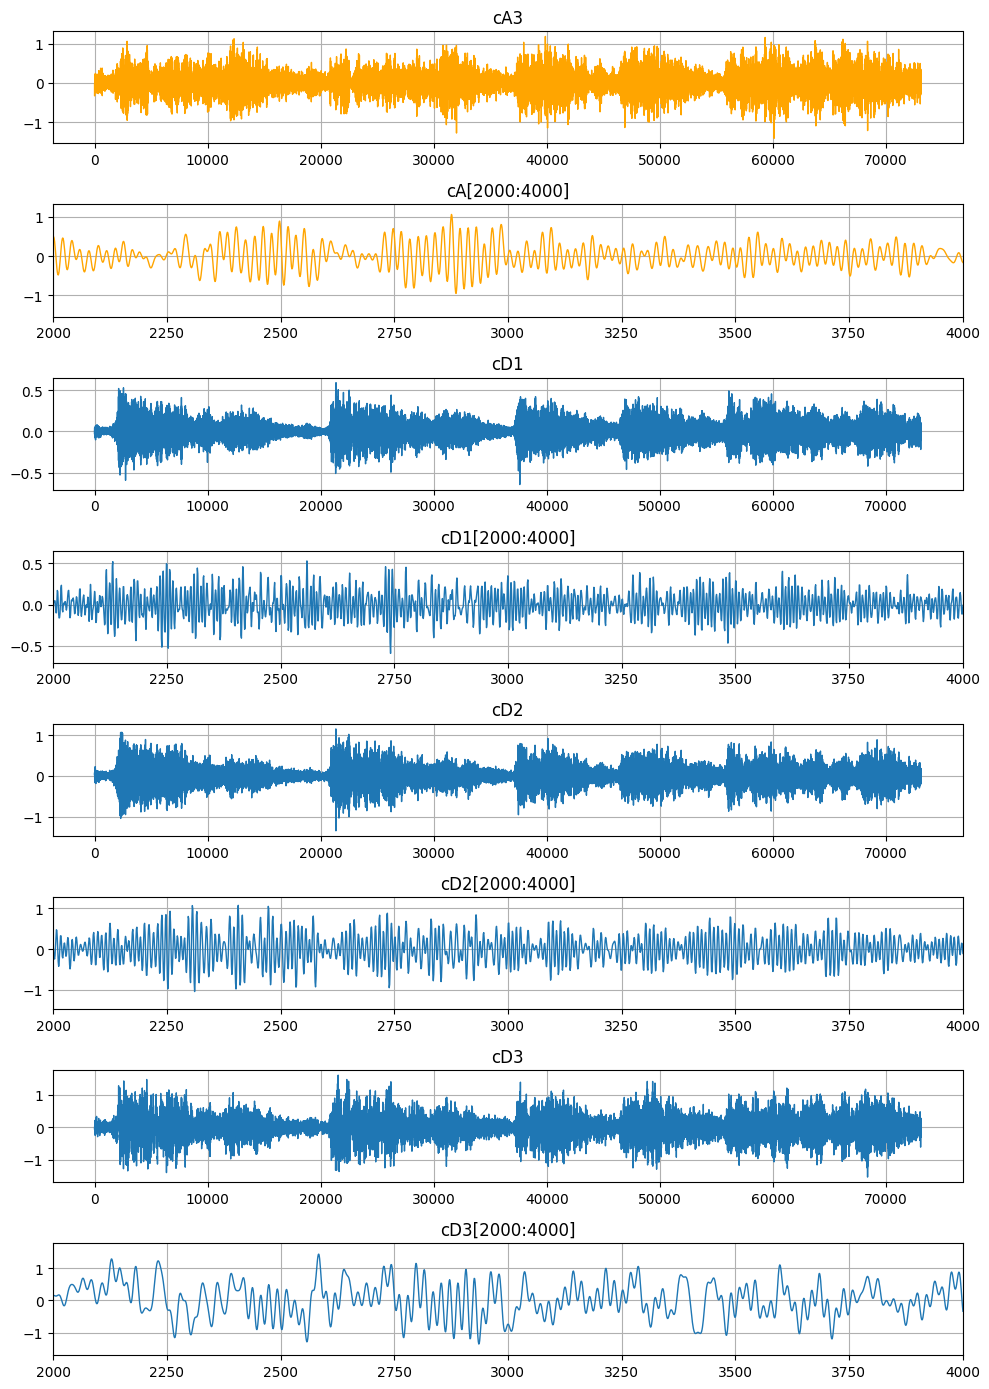

In [11]:
plot_decomposed_signal(cA_at_level, cDs, level, figsize=(10, 14), where_to_save_fig=IMG_FOLDER / 'problem1-1-approximated-and-detailed-coeffs.pdf')

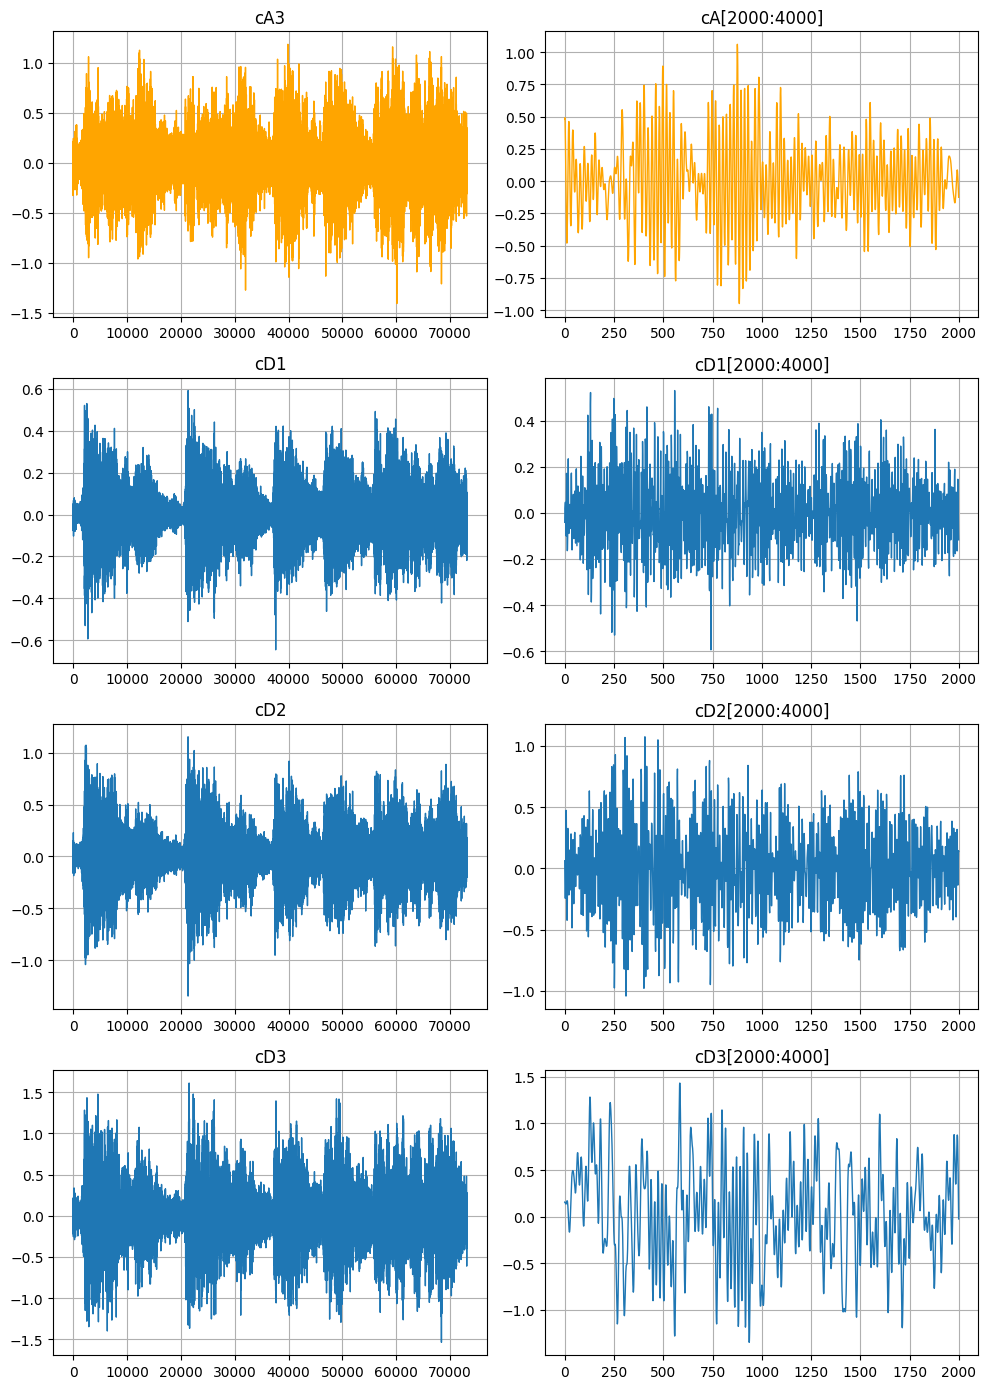

In [15]:
rows = level + 1
cols = 2
interval = slice(*zoomed_in_interval)

_, axs = plt.subplots(rows, cols, figsize=(10, 14))

# plot the approximation coefficients at the deepest level

cA_plot_color = 'orange'

axs[0, 0].plot(cA_at_level, linewidth=1, color=cA_plot_color)
axs[0, 0].set_title(f'cA{level}')
axs[0, 0].grid()
axs[0, 1].plot(cA_at_level[interval], linewidth=1, color=cA_plot_color)
axs[0, 1].set_title('cA' + f'[{zoomed_in_interval[0]}:{zoomed_in_interval[1]}]')
axs[0, 1].grid()

# plot the detail coefficients at each level in descending order
for i, coeff, title in zip([*range(1, rows)], cDs, [f'cD{i+1}' for i in range(level)]):
    axs[i, 0].plot(coeff, linewidth=1)
    axs[i, 0].set_title(title)
    axs[i, 0].grid()
    axs[i, 1].plot(coeff[interval], linewidth=1)
    axs[i, 1].set_title(title + f'[{zoomed_in_interval[0]}:{zoomed_in_interval[1]}]')
    axs[i, 1].grid()

plt.tight_layout()
plt.savefig(IMG_FOLDER / 'problem1-1-approximated-and-detailed-coeffs.pdf', format='pdf')    
plt.show()

### 1.2 Plot the reconstructed signal obtained using `db1` and `db2` wavelets

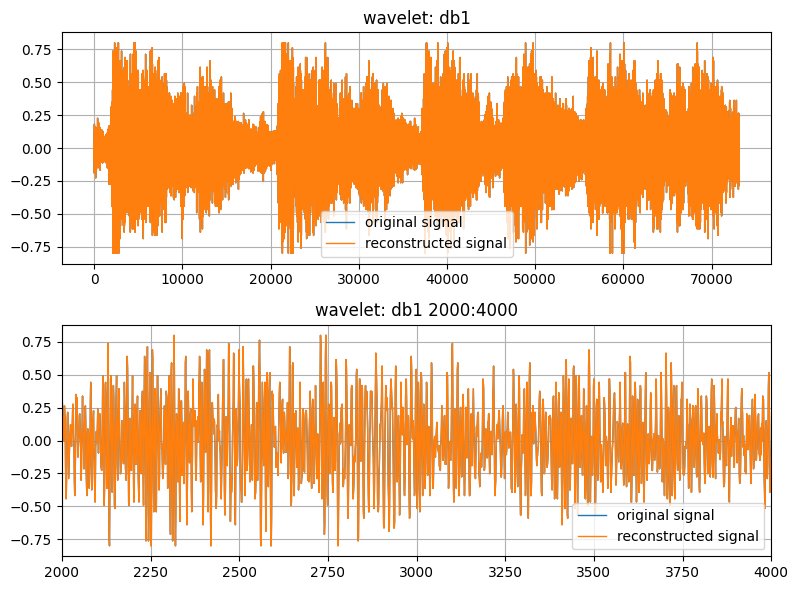

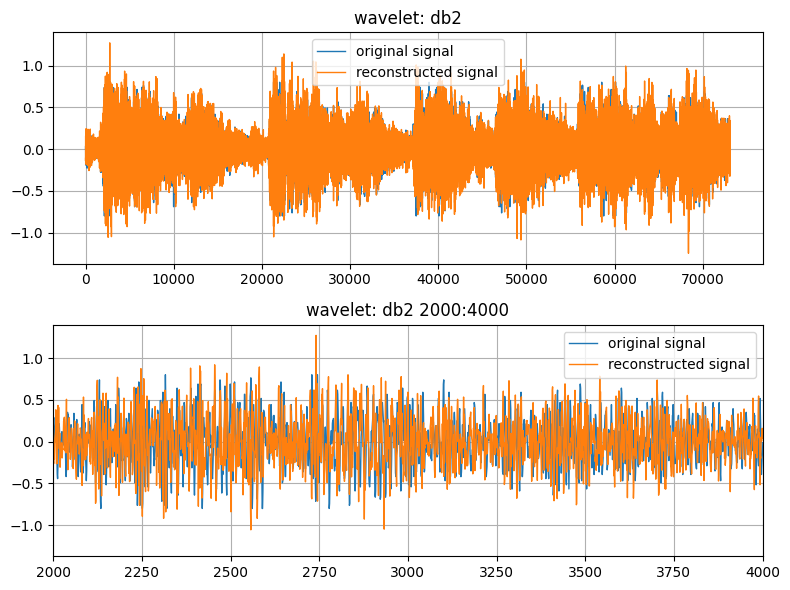

In [108]:
reconstructed_signals = {}

for i, wavelet in enumerate(['db1', 'db2']):
    coeffs = pywt.wavedec(y, 'db1', level=level)

    if wavelet == 'db2':
        coeffs = [
            np.concatenate([coeff, np.array([0])])
            for coeff in coeffs
        ]
    

    reconstructed_signal = pywt.waverec(coeffs, wavelet, mode='symmetric', axis=-1)
    
    _, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(8, 6))
    ax1.plot(y, label='original signal', linewidth=1)
    ax1.plot(reconstructed_signal, label='reconstructed signal', linewidth=1)
    ax1.set_title(f'wavelet: {wavelet}')
    ax1.legend()
    ax1.grid()

    ax2.plot(y, label='original signal', linewidth=1)
    ax2.plot(reconstructed_signal, label='reconstructed signal', linewidth=1)
    ax2.set_title(f'wavelet: {wavelet} {zoomed_in_interval[0]}:{zoomed_in_interval[1]}')
    ax2.set_xlim(zoomed_in_interval)
    ax2.legend()
    ax2.grid()

    really_zoomed_in_interval_start = 2700
    really_zoomed_in_interval_length = 100

    ax3.plot(y, label='original signal', linewidth=1)
    ax3.plot(reconstructed_signal, label='reconstructed signal', linewidth=1)
    ax3.set_title(f'wavelet: {wavelet} {really_zoomed_in_interval_start}:{really_zoomed_in_interval_start + really_zoomed_in_interval_length}')
    ax3.set_xlim(really_zoomed_in_interval_start, really_zoomed_in_interval_start + really_zoomed_in_interval_length)
    ax3.legend()
    ax3.grid()

    plt.tight_layout()
    plt.savefig(IMG_FOLDER / f'problem1-2-reconstructed-signal-{wavelet}.pdf', format='pdf')
    plt.show()

    reconstructed_signals[wavelet] = reconstructed_signal

### 1.3 Hear the reconstructed signal obtained using `db1` and `db2` wavelets. Report on your findings.

In [17]:
for wavelet, reconstructed_signal in reconstructed_signals.items():
    file = f'reconstructed_signal_{wavelet}.wav'
    sp.io.wavfile.write(file, Fs, reconstructed_signal.astype(np.float32))

### FINDINGS
No audible difference between the two wavelets. The reconstructed signal is the same as the original signal.

In [18]:
# play the temporary file with ffplay
!ffplay -nodisp -autoexit $file

/bin/sh: line 1: ffplay: command not found


In [19]:
!mpv --no-video {file} # play the temporary wav file with mpv

/bin/sh: line 1: mpv: command not found


### 1.4 Also, comment on the error obtained on the reconstructed signals for `db1` and `db2`.

In [20]:
def rmse(x: np.ndarray, y: np.ndarray) -> float:
    """RMSE between two signals"""
    assert x.shape == y.shape, f'x.shape: {x.shape}, y.shape: {y.shape}'
    return np.sqrt(np.mean((x - y)**2) / len(x))

for wavelet, reconstructed_signal in reconstructed_signals.items():
    if len(reconstructed_signal) > len(y):
        reconstructed_signal = reconstructed_signal[:len(y)]
    print(f'RMSE between the original signal and the reconstructed signal with {wavelet}: {rmse(y, reconstructed_signal):.3e}')

RMSE between the original signal and the reconstructed signal with db1: 2.721e-19
RMSE between the original signal and the reconstructed signal with db2: 1.001e-03


### FINDINGS
The error is the same for both wavelets. The error is 0.0.

---
# Problem 2

In [21]:
# silicon: start (applying_noise_to_signal.png)
mu = 0.0
sigma = 3
# gaussian noise
noise = np.random.normal(mu, sigma, EEG.shape)
EEG_with_noise = EEG + noise
# silicon: end

In [22]:
EEG.shape
# TODO: the problem says that the signal is an image, but it is actually a 1D signal

(2500,)

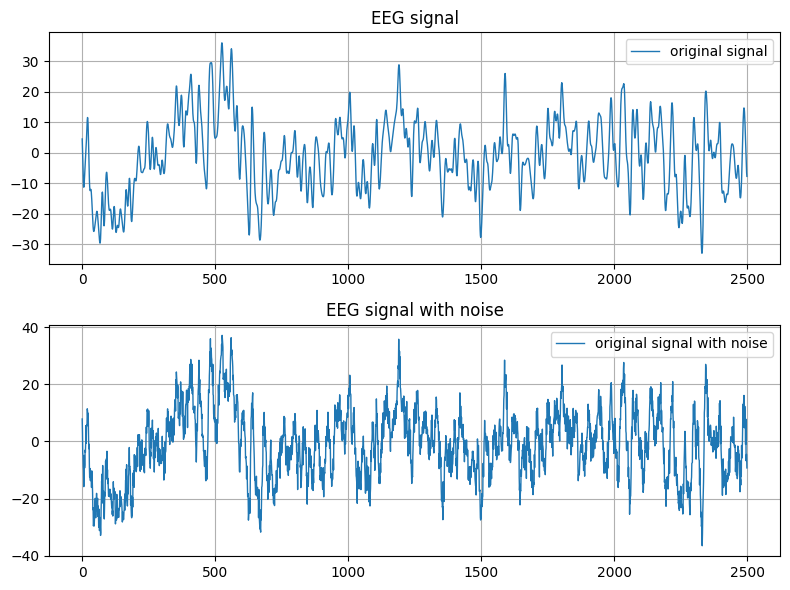

In [23]:
# visulaize the EEG signal with and without noise
_, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 6))
ax1.plot(EEG, label='original signal', linewidth=1)
ax1.set_title('EEG signal')
ax1.legend()
ax1.grid()

ax2.plot(EEG_with_noise, label='original signal with noise', linewidth=1)
ax2.set_title('EEG signal with noise')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.savefig(IMG_FOLDER / 'problem2-1-EEG-signal-with-and-without-noise.pdf', format='pdf')
plt.show()


## 2.1 Compute signal to noise ratio (SNR).

In [46]:
def snr(signal: np.ndarray, noise: np.ndarray) -> float:
    """Signal-to-noise ratio between two signals"""
    assert signal.shape == noise.shape, f'signal.shape: {signal.shape}, y.shape: {noise.shape}'
    return 10 * np.log10(np.mean(signal**2) / np.mean(noise**2))

In [47]:
# SNR = snr(EEG, EEG_with_noise)

# silicon: start
# SNR = 10 * np.log10(np.mean(EEG**2) / np.mean(noise**2))

SNR = snr(EEG, noise)
print(f'SNR: {SNR:.2f} dB')
# silicon: end

SNR: 11.96 dB


## 2.2 Decompose the signal using wavedec (Haar, and db2).

In [26]:
level = 3

decompositions = {}

for wavelet in ['haar', 'db2']:
    coeffs = pywt.wavedec(EEG_with_noise, wavelet, level=level)
    decompositions[wavelet] = coeffs

## 2.3 Plot the subbands obtained using Haar and db2 decomposition.

In [27]:
# refactor plotting code in 1.a and use it here

level = 3

for wavelet, coeffs in decompositions.items():
    cA_at_level, cDs = extract_cA_and_cDs_from_wavedecn(coeffs, level)
    plot_decomposed_signal(cA_at_level, cDs, level, figsize=(10, 14), where_to_save_fig=IMG_FOLDER / f'problem2-3-subbands-{wavelet}.pdf')


len(coeffs): 4


KeyError: 'da'

## 2.4 Observe the subbands and list your observations.

## 3.a Compute the SNR for different $n$ values and values of σ = {0.5, 1, 2, 4}

In [28]:
np.sqrt(np.mean(noise**2))

2.9923248692058926

![](./screenshots/estimate-sigma.png)

combination: [ 1] with wavelet: [db1  ] and sigma: [1.9972] and threshold: [7.5422]
combination: [ 2] with wavelet: [db1  ] and sigma: [0.5000] and threshold: [1.8882]
combination: [ 3] with wavelet: [db1  ] and sigma: [1.0000] and threshold: [3.7765]
combination: [ 4] with wavelet: [db1  ] and sigma: [2.0000] and threshold: [7.5530]
combination: [ 5] with wavelet: [db1  ] and sigma: [4.0000] and threshold: [15.1059]


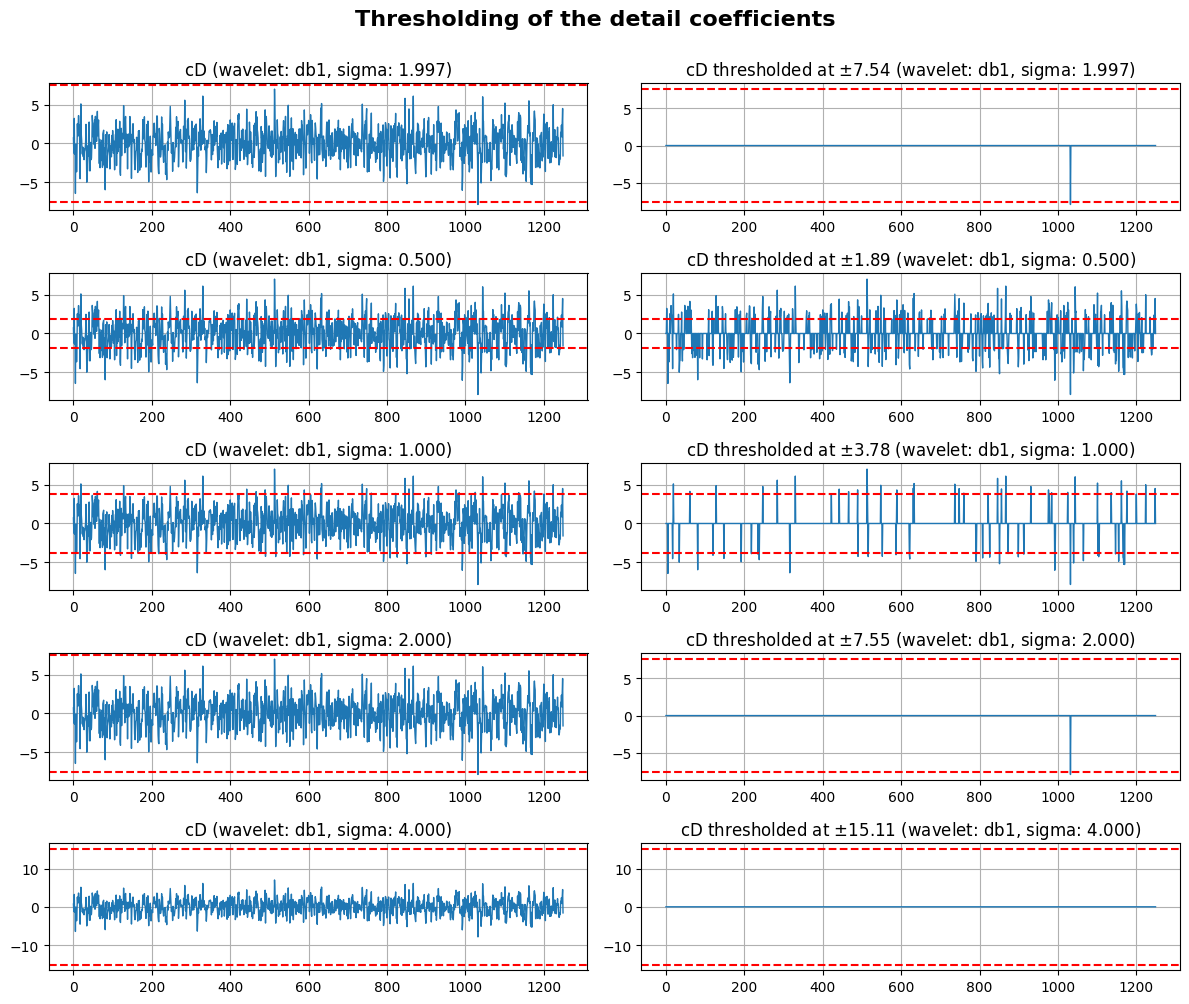

In [97]:
_, cD = pywt.dwt(noisy_EEG, 'db1')
noise_level_estimate = np.median(np.abs(cD)) / 0.6745

sigmas = [
    noise_level_estimate,
    0.5,
    1,
    2,
    4
]
wavelets = [
    # 'haar', 
    'db1',
    # 'db2'
]

fig, axs = plt.subplots(len(wavelets) * len(sigmas), 2, figsize=(12, 10))

fig.suptitle('Thresholding of the detail coefficients', fontsize=16, fontweight='bold', y=1.0)

EEG_denoised = {}

denoised_EEG_df = pl.DataFrame()

for i, wavelet in enumerate(wavelets):
    for j, sigma in enumerate(sigmas):

        cA, cD = pywt.dwt(noisy_EEG, wavelet)
        n = len(cD) # number of detail coefficients
        T = sigma * np.sqrt(2 * np.log(n))  # threshold

        print(f'combination: [{i * len(sigmas) + (j+1):2}] with wavelet: [{wavelet:5}] and sigma: [{float(sigma):.4f}] and threshold: [{T:.4f}]')
        # `hard` thresholding is used, as we do not want to
        # modify the values which is >= T
        cD_thresholded: np.ndarray = pywt.threshold(cD, T, mode='hard')

        EEG_with_noise_reconstructed = pywt.idwt(cA, cD_thresholded, wavelet)

        EEG_denoised[(wavelet, sigma)] = {
            'signal': EEG_with_noise_reconstructed,
            # 'SNR': snr(EEG_with_noise_reconstructed, EEG_with_noise), # TODO: should EEG be subtracted from EEG_with_noise_reconstructed?
            'SNR': snr(EEG_with_noise_reconstructed, noisy_EEG - EEG), # TODO: should EEG be subtracted from EEG_with_noise_reconstructed?
            'RMSE': rmse(EEG_with_noise_reconstructed, noisy_EEG - EEG),
        }

        idx = i * len(sigmas) + j
        ax = axs[idx]
        
        ax[0].plot(cD, label='cD', linewidth=1)
        ax[0].set_title(f'cD (wavelet: {wavelet}, sigma: {sigma:.3f})')
        ax[0].axhline(y=T, linestyle='dashed', color='red')
        ax[0].axhline(y=-T, linestyle='dashed', color='red')
        ax[0].grid()

        ax[1].plot(cD_thresholded, label='cD thresholded', linewidth=1)
        ax[1].set_title(f'cD thresholded at $\pm{T:.2f}$ (wavelet: {wavelet}, sigma: {sigma:.3f})')
        ax[1].axhline(y=T, linestyle='dashed', color='red')
        ax[1].axhline(y=-T, linestyle='dashed', color='red')
        ax[1].grid()

plt.tight_layout()
plt.savefig(IMG_FOLDER / 'problem3-thresholding-of-detail-coefficients.pdf', format='pdf')
plt.show()

In [107]:
for (wavelet, sigma), denoised_signal in EEG_denoised.items():
    print(f'wavelet: {wavelet}, sigma: {sigma:.3f}, SNR: {denoised_signal["SNR"]:.2f} dB, RMSE: {denoised_signal["RMSE"]:.3e}')


print()
print('SNR')
for (wavelet, sigma), denoised_signal in EEG_denoised.items():
    print(f'{sigma:.3f} & {denoised_signal["SNR"]:.2f} dB \\\\')

print()
print('RMSE')
for (wavelet, sigma), denoised_signal in EEG_denoised.items():
    print(f'{sigma:.3f} & {denoised_signal["RMSE"]:.3f} \\\\')


wavelet: db1, sigma: 1.997, SNR: 16.82 dB, RMSE: 2.378e-01
wavelet: db1, sigma: 0.500, SNR: 16.87 dB, RMSE: 2.372e-01
wavelet: db1, sigma: 1.000, SNR: 16.84 dB, RMSE: 2.376e-01
wavelet: db1, sigma: 2.000, SNR: 16.82 dB, RMSE: 2.378e-01
wavelet: db1, sigma: 4.000, SNR: 16.82 dB, RMSE: 2.378e-01

SNR
1.997 & 16.82 dB \\
0.500 & 16.87 dB \\
1.000 & 16.84 dB \\
2.000 & 16.82 dB \\
4.000 & 16.82 dB \\

RMSE
1.997 & 0.238 \\
0.500 & 0.237 \\
1.000 & 0.238 \\
2.000 & 0.238 \\
4.000 & 0.238 \\


## 3.b Plot the original, noisy, and denoised signal in anyone case.

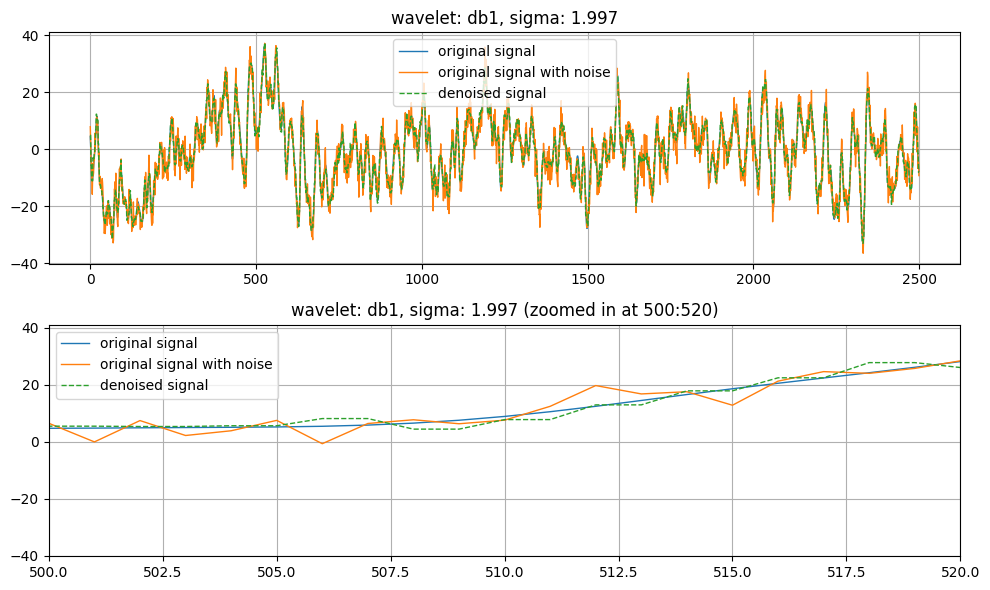

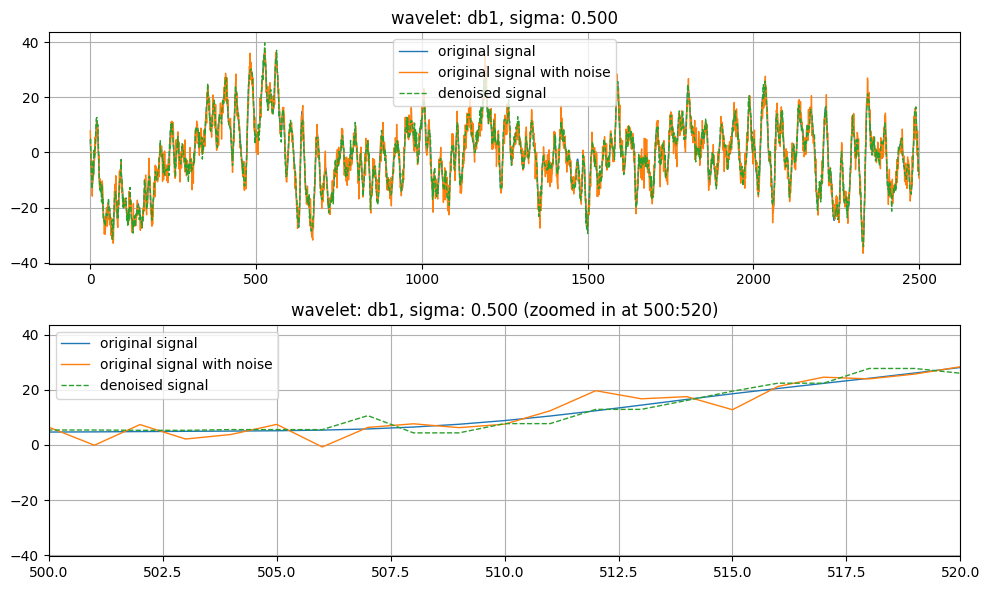

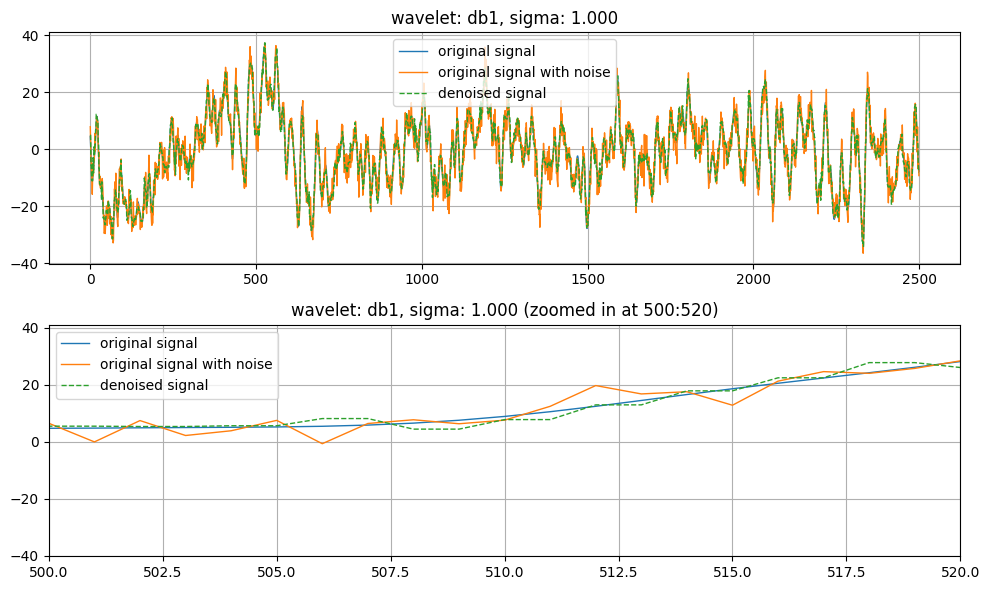

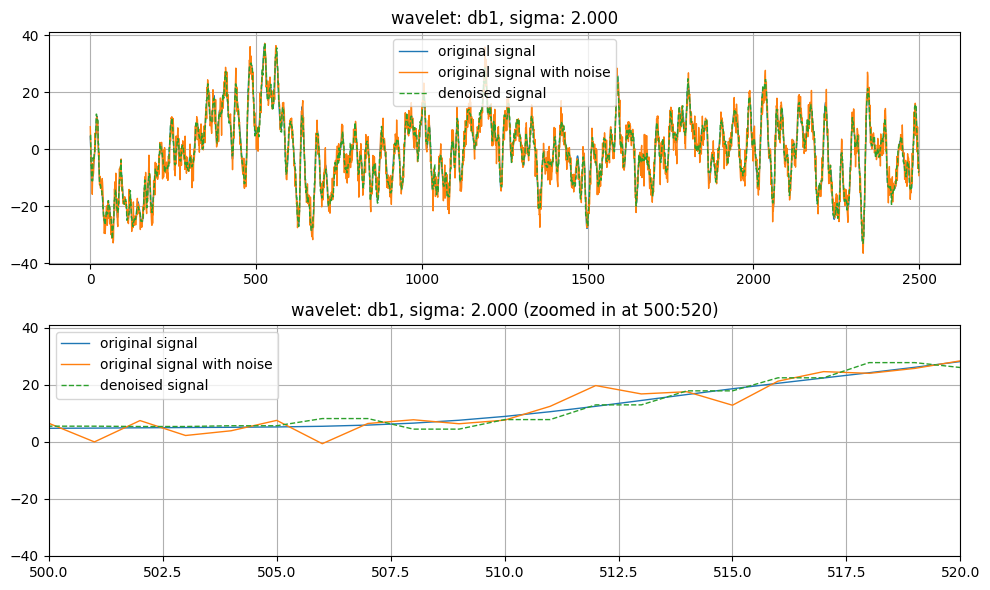

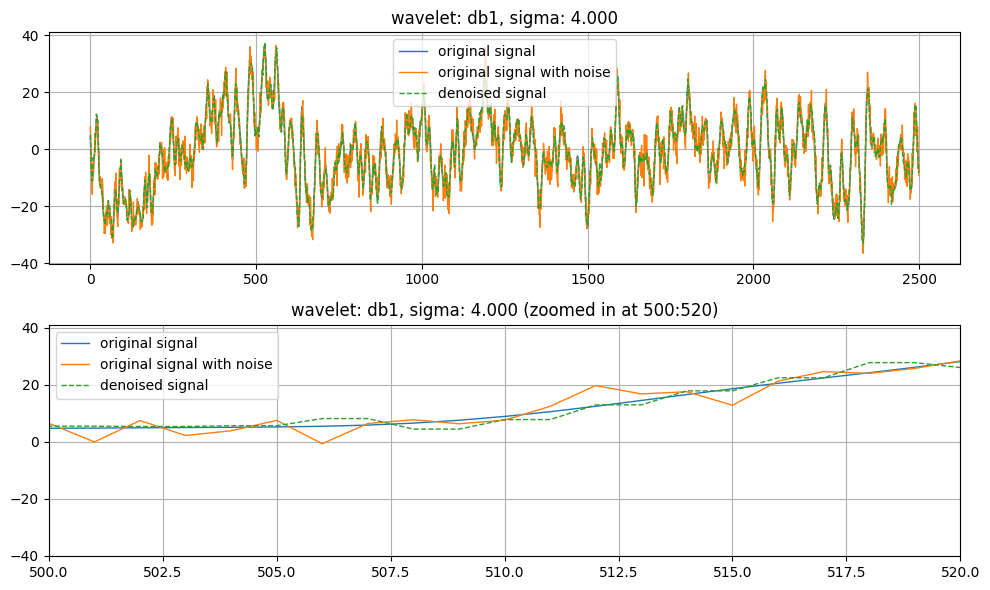

In [104]:
xlim_start = 500
xlim_length = 20


for (wavelet, sigma), signal in EEG_denoised.items():
    # plot original, noisy and denoised signal
    denoised_signal = signal['signal']
    _, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 6))
    ax1.plot(EEG, label='original signal', linewidth=1)
    ax1.plot(EEG_with_noise, label='original signal with noise', linewidth=1)
    ax1.plot(denoised_signal, label='denoised signal', linewidth=1, linestyle='dashed')
    ax1.set_title(f'wavelet: {wavelet}, sigma: {sigma:.3f}')
    ax1.legend()
    ax1.grid()

    ax2.plot(EEG, label='original signal', linewidth=1)
    ax2.plot(EEG_with_noise, label='original signal with noise', linewidth=1)
    ax2.plot(denoised_signal, label='denoised signal', linewidth=1, linestyle='dashed')
    ax2.set_title(f'wavelet: {wavelet}, sigma: {sigma:.3f} (zoomed in at {xlim_start}:{xlim_start+xlim_length})')
    ax2.set_xlim(xlim_start, xlim_start + xlim_length)
    ax2.legend()
    ax2.grid()
    plt.tight_layout()
    plt.savefig(IMG_FOLDER / f'problem3-denoised-signal-wavelet-{wavelet}-sigma-{sigma:.3f}.pdf', format='pdf')

plt.show()


## 3.c Evaluate the RMSE and comment on your interpretations for each case.

In [75]:
df = pl.DataFrame({"a": [[1,2], [3,4], [5.6]], "b": [4, 5, 6]})
# df.columns({'c': [7,8,9]})
df['a'][1:2]

# append row to df
# df = df.append({'a': [7,8,9], 'b': 10}, ignore_index=True)
for item in df['a']:
    print(item)
    

[1, 2]
[3, 4]
[5.6]


In [82]:
from tabulate import tabulate

latex_tbl: str = tabulate(df, headers=['a', 'b'], tablefmt='latex')

with open(TBLS_FOLDER / 'problem-3c-RMSE.tex', 'w') as f:
    f.write(latex_tbl)

print(latex_tbl)

\begin{tabular}{lll}
\hline
        & a      & b     \\
\hline
 [1, 2] & [3, 4] & [5.6] \\
 4      & 5      & 6     \\
\hline
\end{tabular}


In [83]:
tablefmts = [
    "latex",
"latex_raw",
"latex_booktabs",
"latex_longtable"
]

for tablefmt in tablefmts:
    print(tablefmt)
    print(tabulate(df, headers=['a', 'b'], tablefmt=tablefmt))

latex
\begin{tabular}{lll}
\hline
        & a      & b     \\
\hline
 [1, 2] & [3, 4] & [5.6] \\
 4      & 5      & 6     \\
\hline
\end{tabular}
latex_raw
\begin{tabular}{lll}
\hline
        & a      & b     \\
\hline
 [1, 2] & [3, 4] & [5.6] \\
 4      & 5      & 6     \\
\hline
\end{tabular}
latex_booktabs
\begin{tabular}{lll}
\toprule
        & a      & b     \\
\midrule
 [1, 2] & [3, 4] & [5.6] \\
 4      & 5      & 6     \\
\bottomrule
\end{tabular}
latex_longtable
\begin{longtable}{lll}
\hline
        & a      & b     \\
\hline
\endhead
 [1, 2] & [3, 4] & [5.6] \\
 4      & 5      & 6     \\
\hline
\end{longtable}
